scresonators DCM fit test — with robust normalization and preprocessing disabled

Reference: https://github.com/yalgaeahn/scresonators

In [22]:
import numpy as np
# Load arrays produced by LabOne Q workflow artifacts
S21 = np.load("calculate-signal-magnitude-and-phase.output.data-raw.npy")
freqs = np.load("resonator-spectroscopy.input.frequencies.npy")
# Basic sanitization: drop any NaN/Inf
mask = np.isfinite(freqs) & np.isfinite(S21.real) & np.isfinite(S21.imag)
freqs = freqs[mask]
S21 = S21[mask]

In [23]:
# Quick sanity check
(S21.shape, freqs.shape, S21.dtype, freqs.dtype, float(freqs.min()), float(freqs.max()))

((201,),
 (201,),
 dtype('complex128'),
 dtype('float64'),
 6725000000.0,
 6729000000.0)

In [24]:
import os, sys, subprocess
# 1) Normalize S21 by the average of edge points to bring off-resonant region near 1+0j
k = max(5, len(S21)//10)
ref = np.mean(np.r_[S21[:k], S21[-k:]])
S21n = S21 * np.exp(-1j*np.angle(ref)) / (np.abs(ref) if np.abs(ref) != 0 else 1.0)

# 2) Import scresonators (clone lightweight copy if not available)
try:
    from src.resonator import Resonator
    from src.fit_methods.dcm import DCM
except ModuleNotFoundError:
    if not os.path.exists("/tmp/scresonators/src"):
        subprocess.run(["git", "clone", "--depth", "1", "https://github.com/yalgaeahn/scresonators", "/tmp/scresonators"], check=True)
    sys.path[:0] = ["/tmp/scresonators", "/tmp/scresonators/src"]
    from src.resonator import Resonator
    from src.fit_methods.dcm import DCM

# 3) Fit with preprocessing disabled first (our data is already normalized)
res = Resonator()
res.load_data(fdata=freqs, sdata=S21n)
res.set_fitting_strategy(strategy=DCM)
res.fitter.remove_elec_delay = True
res.fitter.preprocess_circle = True

try:
    results = res.fit(verbose=False)
except Exception as e:
    print("First attempt failed:", e)
    # Backup: enable delay removal with a conservative initial delay guess
    res.fitter.remove_elec_delay = True
    res.fitter.delay_guess = 0.0
    # Ensure the same strategy (class, not instance) is set
    res.set_fitting_strategy(strategy=DCM)
    results = res.fit(verbose=False)

# 4) Display results
print("Fit complete. Extracted parameters:")
out = {}
for k in sorted(results.keys()):
    print(f"  {k}: {results[k]}")
    try:
        out[k] = (float(results[k].value), float(getattr(results[k], 'stderr', float('nan'))))
    except Exception:
        pass
out

Q_guess: 6934.680412371134
initial delay guess: nan
First attempt failed: At least three unique points are required to define a circle.
Q_guess: 6934.680412371134
initial delay guess: nan


/tmp/scresonators/src/fitter.py:323: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  lrg_result[n] = linregress(trimmed_freq[n], trimmed_phase)


ValueError: At least three unique points are required to define a circle.

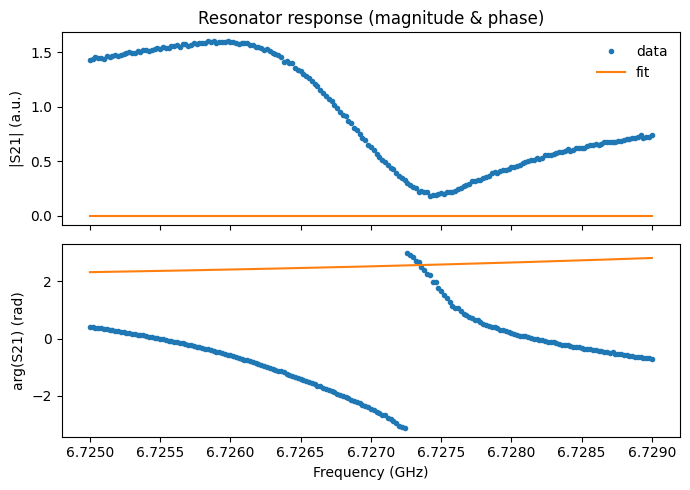

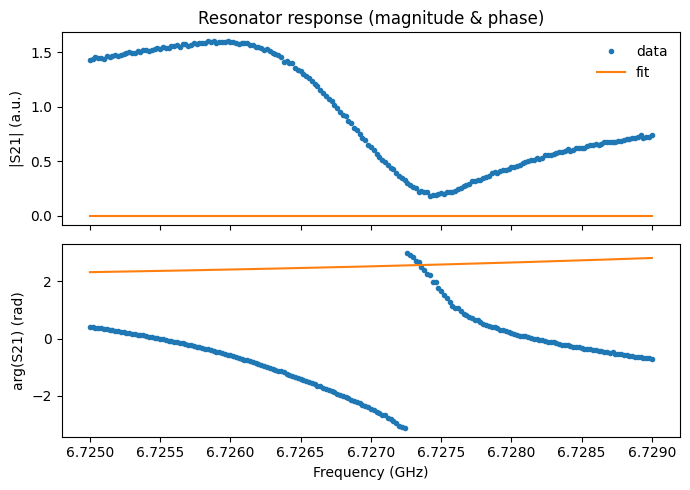

In [27]:
# Plot magnitude and phase with fitted curve overlay
import numpy as np
import matplotlib.pyplot as plt

fit_sw = np.linspace(freqs.min(), freqs.max(), 1001)
fit_vals = DCM.fit_function(fit_sw, results)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(7, 5))
axs[0].plot(freqs/1e9, np.abs(S21n), 'o', ms=3, label='data')
axs[0].plot(fit_sw/1e9, np.abs(fit_vals), '-', label='fit')
axs[0].set_ylabel('|S21| (a.u.)')
axs[0].legend(frameon=False)
axs[0].set_title('Resonator response (magnitude & phase)')

axs[1].plot(freqs/1e9, np.angle(S21n), 'o', ms=3)
axs[1].plot(fit_sw/1e9, np.angle(fit_vals), '-')
axs[1].set_xlabel('Frequency (GHz)')
axs[1].set_ylabel('arg(S21) (rad)')
fig.tight_layout()
fig

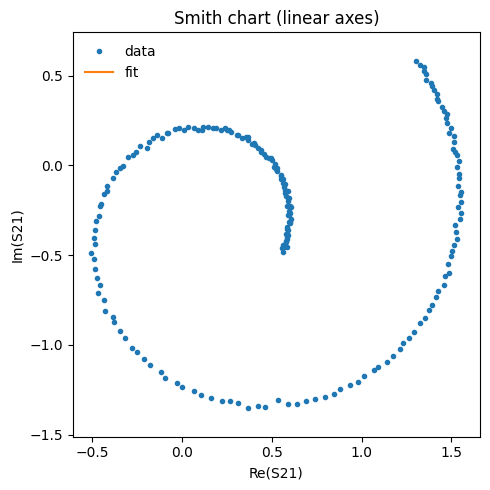

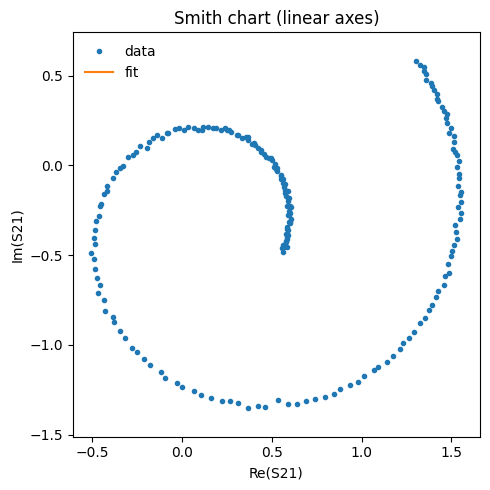

In [25]:
# Plot Smith chart (Re vs Im) with fitted curve overlay
import numpy as np
import matplotlib.pyplot as plt

fit_sw = np.linspace(freqs.min(), freqs.max(), 1001)
fit_vals = DCM.fit_function(fit_sw, results)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.real(S21n), np.imag(S21n), 'o', ms=3, label='data')
ax.plot(np.real(fit_vals), np.imag(fit_vals), '-', label='fit')
ax.set_xlabel('Re(S21)')
ax.set_ylabel('Im(S21)')
ax.axis('equal')
ax.legend(frameon=False)
ax.set_title('Smith chart (linear axes)')
fig.tight_layout()
fig